In [1]:
import osmnx as ox
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import json
print("loaded")
colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 'brown', 'grey', 'lightblue', 'cyan', 'magenta', 'red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 'brown', 'grey', 'lightblue', 'cyan', 'magenta']
# secteurs à étudier
arrondissements = [
    'Ahuntsic-Cartierville',
    'Anjou',
    'Côte-des-Neiges–Notre-Dame-de-Grâce',
    'Lachine',
    'LaSalle',
    'Le Plateau-Mont-Royal',
    'Le Sud-Ouest',
    'L\'Île-Bizard–Sainte-Geneviève',
    'Mercier–Hochelaga-Maisonneuve',
    'Montréal-Nord',
    'Outremont',
    'Pierrefonds-Roxboro',
    'Rivière-des-Prairies–Pointe-aux-Trembles',
    'Rosemont–La Petite-Patrie',
    'Saint-Laurent',
    'Saint-Léonard',
    'Verdun',
    'Ville-Marie',
    'Villeray–Saint-Michel–Parc-Extension'
]

loaded


In [2]:
# get Osmnx graph from name of a sector
def get_graph(name):
    G = ox.graph_from_place(name, network_type='drive') # retain_all=True
    G = ox.project_graph(G)
    nx.weakly_connected_components(G)
    return G

In [4]:
# you can call the getEulerienGraph function with the name of the sector
# it will give you the eulerian path of this sector

def read_json(filename):
    with open(filename, "r") as file:
        data = json.loads(file.read())
    return data

def transform_to_tuples(list_of_lists):
    return [tuple(sub_list) for sub_list in list_of_lists]

def getEulerienGraph(name):
    i = arrondissements.index(name)
    chemin = read_json("../drone_scouting/paths.txt")
    return (transform_to_tuples(chemin[i]))

In [12]:
sectorToStudy = "Verdun"
# get the eulerien graph of the sector of verdun
paths = getEulerienGraph(sectorToStudy)
print("le chemin eulerien de " + sectorToStudy + " possède " + str(len(paths)) + " routes")

le chemin eulerien de Verdun possède 603 routes


In [8]:
def is_in_graph(G, x, y):
    for (a, b, w) in G:
        if (x == a and y == b):
            return True
    return False

def getGraphFromList(list):
    G = []
    for i in range(0, len(list) - 1):
        G.append((list[i], list[i+1]))
    return G

# g is the graph from get_graph
# path is the list of path of the eulerien traval
# the function return the path in order to travel all roads
def replace_nodes2(G, path):
    i = 0
    goodPath = []
    undirected = G.to_undirected()
    k = 0 # to check how many fake roads have been added
    
    while(i < len(path)):
        a,b = path[i]
            
        # this path doesn't exist in our graph, 
        # we need to find shortest path 
        if(not is_in_graph(G.edges, a, b)):
            try:
                p = nx.shortest_path(undirected, source=a, target=b)
                l = getGraphFromList(p)
                goodPath += l
            except:
                goodPath.append((a,b))
                k += 1
        else:
            goodPath.append((a,b))
        i += 1
    
    print("route non trouvée: ", k)
    return goodPath

In [21]:
def path_length(edges, g):
    dist_arr = []
    for u,v,k,obj in g.edges.data(keys=True):
        dist_arr.append((u,v,obj['length']))
    length = 0
    for u,v in edges:
        for u1,v1,l in dist_arr:
            if (u1 == u and v1 == v):
                length += l
    return length


def add_length(edges, g):
    dist_arr = []
    for u,v,k,obj in g.edges.data(keys=True):
        dist_arr.append((u,v,obj['length']))
    for i in range (len(edges)):
        u,v = edges[i]
        for u1,v1,l in dist_arr:
            if ((u1 == u and v1 == v) or (u1 == v and v1 == u)):
                edges[i] = (u,v,l)


def saveInFile(name, paths):        
    with open(name + "_good_path.txt", "w+") as file:
        file.write(json.dumps(paths))

In [10]:
# pour obtenir le graphe orienté de la zone
g = get_graph(sectorToStudy + ", Montreal, Canada")

In [17]:

true_path2 = replace_nodes2(g, paths)
print("Pour déneiger cette zone, on doit passer par " + str(len(true_path2)) + " routes")

add_length(true_path2, g)

route non trouvée:  0
Pour déneiger cette zone, on doit passer par 603 routes


Le véhicile doit parcourir : 60.790264000000015 km
road not found: 0


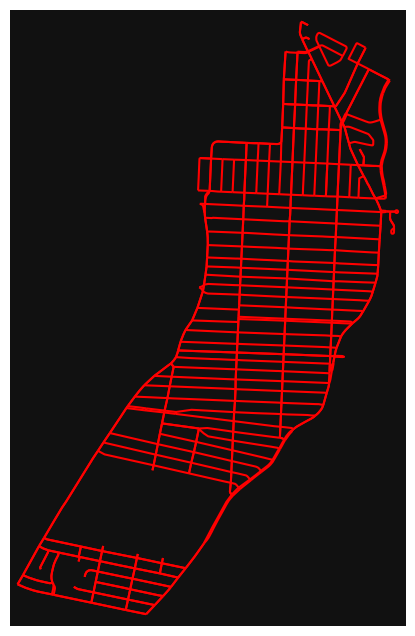

In [24]:
# sur le graphe : 
# en rouge : les routes que le véhicule va emprunter pour déneiger la zone
# en bleu : les routes que le véhicule n'emprunte pas

import matplotlib.pyplot as plt

def edge_colors(G, eulerian_edges):
    i = 0
    colors = []
    for u, v, _ in G.edges(keys=True):
        if (u, v) in eulerian_edges or (v, u) in eulerian_edges:
            colors.append('red')
        else:
            i +=1
            colors.append('blue')
    print("nombre de routes non empruntée:",i)
    return colors

# Get the edges of the eulerian path
eulerian_edges = [(u, v) for u, v, l in true_path2]

distance = path_length(eulerian_edges, g)
print("Le véhicile doit parcourir : " + str(distance/1000) + " km")

# Set the colors of the edges
ec = edge_colors(g, eulerian_edges)

fig, ax = ox.plot_graph(g, edge_color=ec, edge_linewidth=1.5, node_size=0)
plt.show()

In [26]:
# the part is to do all steps with one function


def getRoad(sector):
    paths = getEulerienGraph(sector)
    g = get_graph(sector + ", Montreal, Canada")
    true_path2 = replace_nodes2(g, paths)
    path_with_distance = add_length(true_path2, g)
    saveInFile(sector, true_path2)


sectorsToStudy = ["Outremont", "Verdun", "Saint-Léonard", "Rivière-des-Prairies–Pointe-aux-Trembles", "Le Plateau-Mont-Royal"]

for sector in sectorsToStudy:
    getRoad(sector)

route non trouvée:  0
route non trouvée:  0
route non trouvée:  0
route non trouvée:  0
route non trouvée:  0


28230.12999999999
28298.447999999993
27901.71200000002


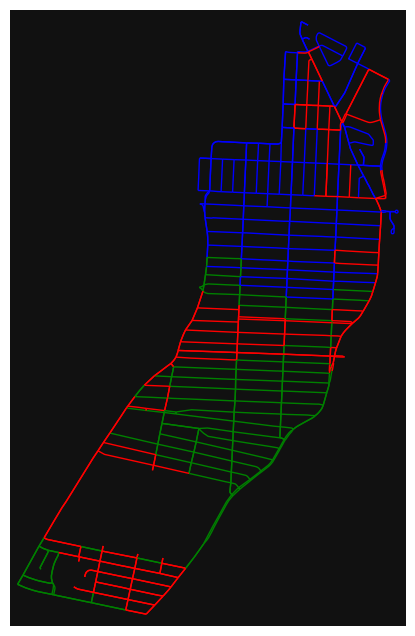

In [27]:
l = read_json("Verdun" + "_good_path.txt")
dist = 0
vehicle_colors = ["red"]

def splitVehiclesPaths(path, nb_v):
    dist = 0
    for _,_,d in path:
        dist += d
    result = []
    i = 0
    curr = 0
    next_step = dist / nb_v
    e = []
    for u,v,d in path:
        if next_step < curr:
            i+=1
            next_step += dist/nb_v
            result.append(e)
            e = []
        e.append((u,v,d))
        curr += d
    if len(e) != 0:
        result.append(e)
    return result
        
def vehicleColorSelect(u,v, paths, colors):
    if (len(paths) != len(colors)):
        print()
        print(len(colors))
        return "orange"
    for i in range(len(paths)):
        temp = [(u,v) for u,v,_ in paths[i]]
        if (u,v) in temp or (v,u) in temp:
            return colors[i]
    return "white"
            

def showAllVehicles(G, paths, v_colors):
    colors = []
    for u, v, _ in G.edges(keys=True):
        colors.append(vehicleColorSelect(u,v,paths,v_colors))
    fig, ax = ox.plot_graph(G, edge_color=colors, edge_linewidth=1, node_size=0)
    plt.show()
    

split = splitVehiclesPaths(l,3)  
for s in split:
    dist = 0
    for _,_,d in s:
        dist += d
    print(dist)
showAllVehicles(g,split, ["red", "green", "blue"])
    



